In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import numpy as np
np.set_printoptions(suppress=True)

### Setup the pretrained model

1. Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification
2. Set the weights file you downloaded into a variable
3. Initialize the base model.Set the input shape and remove the dense layers.No top means it excludes the fully connected layer it uses for classification
4. Load the pre-trained weights you downloaded
5. Freeze the weights of the layers
6. Choose `mixed_7` as the last layer of your base model

In [2]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
#import wget
#url = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
#wget.download(url)

#!wget --no-check-certificate \
#    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#    -O /Models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = 'Models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
#No top means it excludes the fully connected layer it uses for classification
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

2022-10-14 21:53:17.728660: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [5]:
# Choose `mixed_7` as the last layer of your base model

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


### Load dataset

Each Image size = 150X150 pixels

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = 'Datasets/cats_and_dogs_filtered/train',
    labels = 'inferred',
    label_mode = 'binary',
    batch_size = 20,
    image_size=(150,150),
    shuffle=True,  ###False = Get same results
    seed = 16
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory = 'Datasets/cats_and_dogs_filtered/validation',
    labels = 'inferred',
    label_mode = 'binary',
    batch_size = 20,
    image_size=(150,150),
    shuffle=True,  ###False = Get same results
    seed = 16
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory = 'Datasets/rv-test-dog-or-cat/',
    image_size=(150,150),
    label_mode=None, #Does not return label
)
print(train_ds,val_ds,test_ds)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 8 files belonging to 1 classes.
<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))> <BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))> <BatchDataset element_spec=TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None)>


### EDA

Dog = 1, Cat = 0

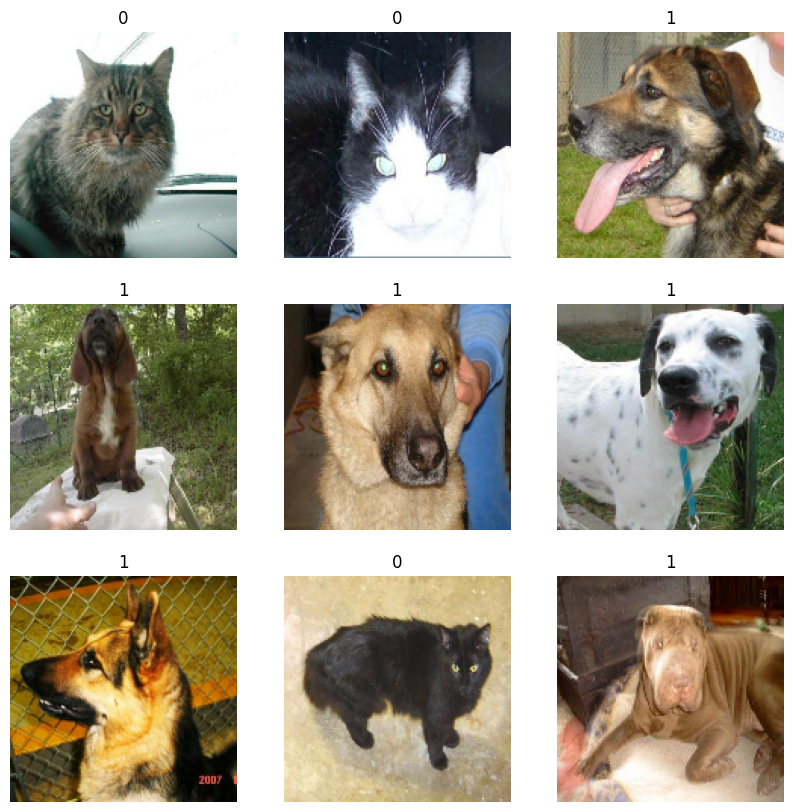

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Feature scaling (Normalization) => Preprocessing layer

- Data augmentation and Dropout are inactive at inference time

In [8]:
#!pip install tensorflow-gpu==2.8.3
#https://stackoverflow.com/questions/73304934/tensorflow-data-augmentation-gives-a-warning-using-a-while-loop-for-converting

In [9]:
# PPL Option 2 : Apply to dataset

train_rescale_augment = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1./255),
    tf.keras.layers.RandomRotation(factor=0.1, fill_mode='nearest'), #360 degrees = 100% => 90 deg = 25% (0.25), 45 deg = 0.125
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest'),
    #tf.keras_cv.layers.RandomShear(x_factor=0.2, y_factor=0.2, fill_mode='nearest'),
    tf.keras.layers.RandomZoom(height_factor=0.2,fill_mode='nearest'),
    tf.keras.layers.RandomFlip(mode='horizontal')
])
train_ds = train_ds.map(lambda x,y : (train_rescale_augment(x),y))

val_test_rescale = tf.keras.layers.Rescaling(scale=1./255)
val_ds = val_ds.map(lambda x,y : (val_test_rescale(x),y))
test_ds_scaled = test_ds.map(lambda x : val_test_rescale(x))

### Build MODEL

- Add Dense layers and append to Inception model
    1. Flatten the output layer to 1 dimension
    2. Add a fully connected layer with 1,024 hidden units and ReLU activation
    3. Add a dropout rate of 0.2
    4. Add a final sigmoid layer for classification
    5. Append the dense network to the base model

In [10]:
#callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,verbose=1)
callback_cp = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'Models/C2W3DogsCatsTL/Checkpoint/dc_model', #_{epoch}',
    monitor = 'val_accuracy',save_best_only = True,save_weights_only = True,verbose=1)


my_dense_layers = tf.keras.layers.Flatten()(last_output)
my_dense_layers = tf.keras.layers.Dense(units=1024, activation='relu')(my_dense_layers)
my_dense_layers = tf.keras.layers.Dropout(0.2)(my_dense_layers)
my_dense_layers = tf.keras.layers.Dense(units=1, activation='sigmoid')(my_dense_layers)
dc_model_transferlearn = tf.keras.Model(inputs=pre_trained_model.input, outputs=my_dense_layers)

dc_model_transferlearn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [11]:
dc_model_transferlearn.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [12]:
dc_model_transferlearn_hist = dc_model_transferlearn.fit(train_ds,
                                                         validation_data = val_ds,
                                                         epochs = 5,
                                                         steps_per_epoch = 100,
                                                         validation_steps = 50,
                                                         callbacks = [callback_cp])

Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 0.2059 - accuracy: 0.9290
Epoch 1: val_accuracy improved from -inf to 0.96600, saving model to Models/C2W3DogsCatsTL/Checkpoint/dc_model
100/100 [==============================] - 117s 1s/step - loss: 0.2059 - accuracy: 0.9290 - val_loss: 0.0997 - val_accuracy: 0.9660
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9890
Epoch 2: val_accuracy did not improve from 0.96600
100/100 [==============================] - 99s 986ms/step - loss: 0.0322 - accuracy: 0.9890 - val_loss: 0.1147 - val_accuracy: 0.9660
Epoch 3/5
100/100 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9970
Epoch 3: val_accuracy did not improve from 0.96600
100/100 [==============================] - 114s 1s/step - loss: 0.0060 - accuracy: 0.9970 - val_loss: 0.1850 - val_accuracy: 0.9590
Epoch 4/5
100/100 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9995
Epoch 4: 

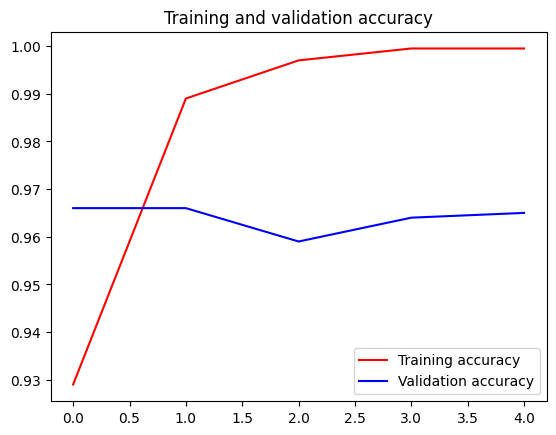

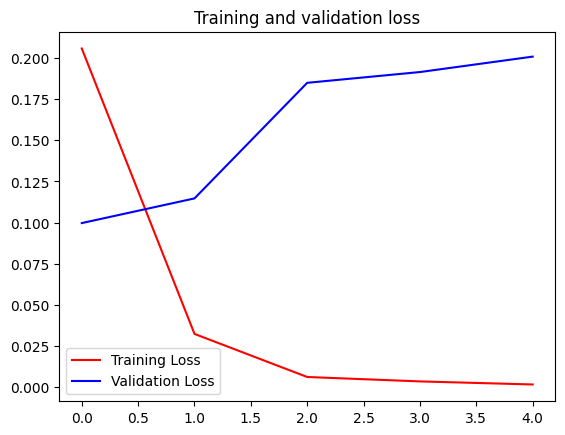

In [13]:
# Plot the model results
acc = dc_model_transferlearn_hist.history['accuracy']
val_acc = dc_model_transferlearn_hist.history['val_accuracy']
loss = dc_model_transferlearn_hist.history['loss']
val_loss = dc_model_transferlearn_hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Predict

Dog = 1, Cat = 0

1/1 [==============================] - 1s 1s/step
[[0.04696637]
 [1.        ]
 [0.        ]
 [1.        ]
 [0.        ]
 [0.00004698]
 [0.9999999 ]
 [0.0024935 ]]
(8, 150, 150, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>
Cat


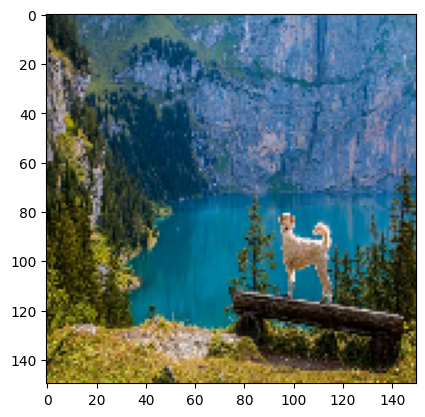

Dog


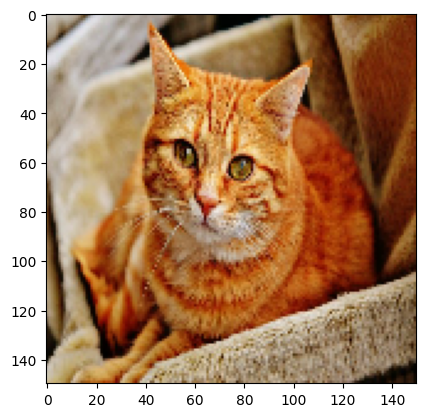

Cat


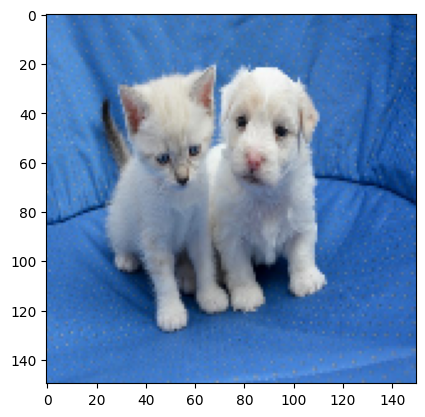

Dog


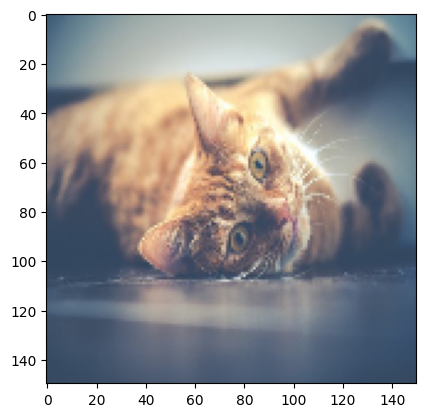

Cat


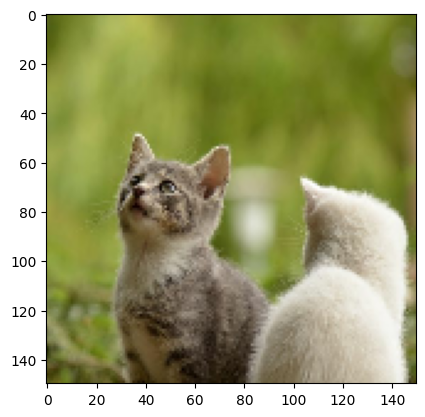

Cat


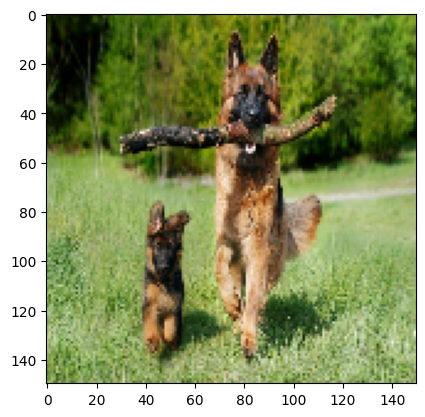

Dog


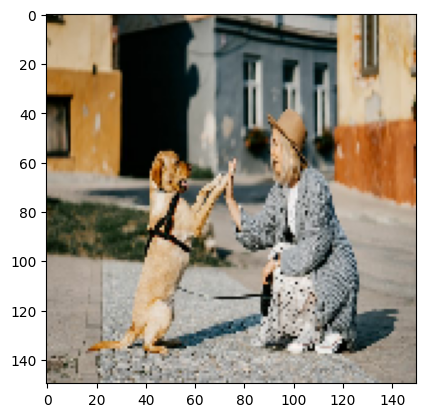

Cat


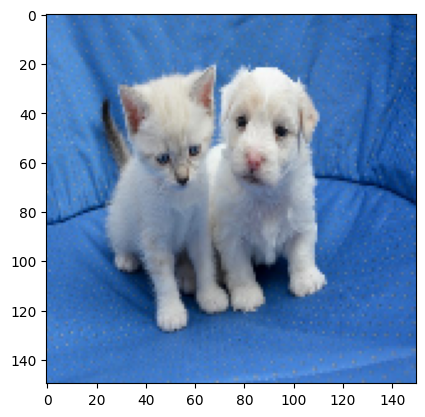

In [14]:
y_pred = dc_model_transferlearn.predict(test_ds_scaled) #new_dc_model.predict(test_ds_scaled)
print(y_pred)
y_pred_label = ["Cat" if el<0.5 else "Dog" for el in y_pred ]

##### Test Set

for x in test_ds:
    print(x.shape,type(x))
    if(x.shape[0]<32):
        for i in range(0,x.shape[0]):
            print(y_pred_label[i])
            plt.imshow(x.numpy()[i].astype('uint8'))  #Float values
            plt.show()